# Similarity model

In [1]:
import tensorflow as tf
import numpy as np
import itertools

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_simmod_grt = global_run_tests
global_run_tests = False

%run visualisation.ipynb
%run dataset.ipynb
%run augmentator.ipynb

global_run_tests = _simmod_grt

_sim_model = None

In [2]:
class SimiratityModel:
    GpuMemoryFraction = .9

    def __init__(self, dataset, augmentator):
        self.data       = dataset
        self._aug       = augmentator
        self._session   = None
        self._graph     = None
        self._is_loaded = False
        self._is_built  = False

    def _similarity_nn(self, image1, image2):
        def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs=inputs,
                filters=filters,
                kernel_size=kernel_size,
                padding=padding,
                activation=tf.nn.relu)
            return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.concat([image1, image2], axis=1)
        l = conv2d_maxpool(l, 16)
        l = conv2d_maxpool(l, 32)
        l = conv2d_maxpool(l, 64)
        l = conv2d_maxpool(l, 128)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=2)
        logits     = l
        similarity = tf.nn.softmax(logits)
        return {'logits':logits, 'similarity':similarity}

    def build(self):
        assert self.data.data_size>0, "Model data is not loaded"
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        with self._graph.as_default(), tf.name_scope('similarity'), tf.device('/gpu:0'):
            # placeholders
            self.image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            self.image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            self.true_pl   = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='true')
            self.lr_pl     = tf.placeholder(dtype=tf.float32, name='lr')
            # network
            self.network   = self._similarity_nn(self.image1_pl, self.image2_pl)
            # operations
            self.logits_op = self.network['logits']
            self.sim_op    = self.network['similarity']
            self.loss_op   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.true_pl, logits=self.logits_op))
            self.train_op  = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
        self._is_built = True

    def train(self, step_num, batch_size, learning_rate = 1e-4, stop_loss=.1, log_every=3, mean_win = 30):
        assert self._is_built,  "Model is not built"
        
        if self._session:
            self._session.close()
        
        gpu_options   = tf.GPUOptions(per_process_gpu_memory_fraction=self.GpuMemoryFraction)
        self._session = tf.Session(graph=self._graph, config=tf.ConfigProto(gpu_options=gpu_options))
        self._session.run(self.init_op)
            
        try:
            losses   = []
            for step in range(step_num):
                img1, img2, true = self.data.get_next_batch(batch_size, self._aug.augment)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.image1_pl: img1,
                    self.image2_pl: img2,
                    self.true_pl  : true,
                    self.lr_pl    : learning_rate
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, mean_win)
                if np.mean(losses[-mean_win:]) < stop_loss:
                    break
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, mean_win)

    def augment(self, images, use_cache=False, rate=1):
        augmented = np.zeros_like(images)
        for i in range(len(images)):
            augmented[i] = self._aug.augment(images[i], use_cache, rate)
        return augmented

    def get_similarity(self, img1, img2):
        return self._session.run(self.sim_op, feed_dict = {
            self.image1_pl: img1,
            self.image2_pl: img2
        })[:,1]

    def get_joint_similarity(self, batch_size):
        def gen_pair_batches(num, bs):
            pairs = itertools.product(range(num), range(num))
            batch = np.zeros(dtype=int, shape=[bs,2])
            i = 0
            for p in pairs:
                batch[i] = p
                i += 1
                if i == bs:
                    i = 0
                    yield batch
            if i > 0:
                yield batch[:i]

        # create
        data_size = self.data.data_size
        images    = self.data.train_images
        joint_sim = np.zeros([data_size, data_size])
        i = 0
        bn = np.ceil(data_size**2/batch_size)
        for b in gen_pair_batches(data_size, batch_size):
            i += 1
            clear_output(True)
            print("%.1f%%  %d/%d" % (i/bn*100, i, bn))
            ind1 = b[:,0]
            ind2 = b[:,1]
            sim  = self.get_similarity(images[ind1], images[ind2])
            for s in range(len(sim)):
                joint_sim[ind1[s], ind2[s]] = sim[s]

        # normalize
        eps = 10e-20
        for i in range(len(joint_sim)):
            joint_sim[i,i] = 0
        joint_sim = joint_sim / (joint_sim.sum()+eps)
        joint_sim = np.maximum(joint_sim, eps)
        
        return joint_sim

## Train

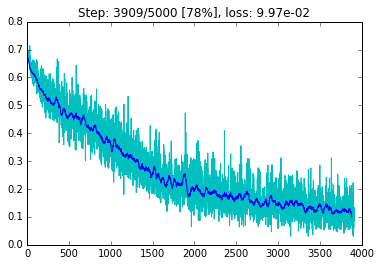

path         : /netforge/datasets/private/roman/coins/images
data_size    : 1000
batch_size   : 100
learning_rate: 1e-04


In [8]:
%%time
def test_train_model(image_shape, step_num, data_size, batch_size, learning_rate, stop_loss):
    aug  = Augmentator()
    data = Dataset(image_shape)
    data.load(_dataset_path, data_size)
    model = SimiratityModel(data, aug)
    model.build()
    model.train(step_num=step_num, batch_size=batch_size, learning_rate=learning_rate, stop_loss=stop_loss)
    print("path         :", model.data.path)
    print("data_size    :", data_size)
    print("batch_size   :", batch_size)
    print("learning_rate: %.0e" % learning_rate)
    return model

if global_run_tests:
    _sim_model = test_train_model(
        image_shape   = [128,128,1],
        step_num      = 5000, 
        data_size     = 1000, 
        batch_size    = 100, 
        learning_rate = 1e-4, 
        stop_loss     = .1)

## Joint similarity

100.0%  2000/2000
joint_similarity: [1000, 1000]
sum: 1.0


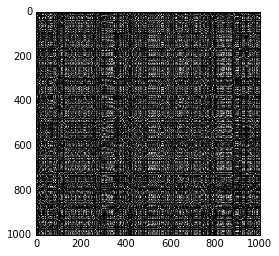

CPU times: user 3min 3s, sys: 1min 29s, total: 4min 33s
Wall time: 7min 26s


In [9]:
%%time
def test_joint_similarity(batch_size):
    joint_similarity = _sim_model.get_joint_similarity(batch_size)
    np.save("data/joint_similarity.npy", joint_similarity)

    print("joint_similarity:", list(joint_similarity.shape))
    print("sum:", joint_similarity.sum())
    plt.imshow(joint_similarity**.1, cmap='gray')
    plt.show()
    
if global_run_tests:
    test_joint_similarity(batch_size=500)

## Test performance

In [11]:
%%time
def test_performance(model, num):
    assert model, "Model is not defined"
    images  = model.data.test_images
    shift   = np.random.randint(len(images))
    
    im1 = np.roll(images, shift  , axis=0)[:num]
    im2 = np.roll(images, shift+1, axis=0)[:num]
    sim = model.get_similarity(im1, im2)

if global_run_tests:
    test_performance(_sim_model, num=256)

CPU times: user 116 ms, sys: 72 ms, total: 188 ms
Wall time: 231 ms


## Test similarity

0.83 0.89 0.82 0.99 0.62 1.00 0.92 0.88 0.97 0.95 0.99 0.99 0.94 0.89 0.93 0.97 0.93 0.83 0.99 0.99
==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ====


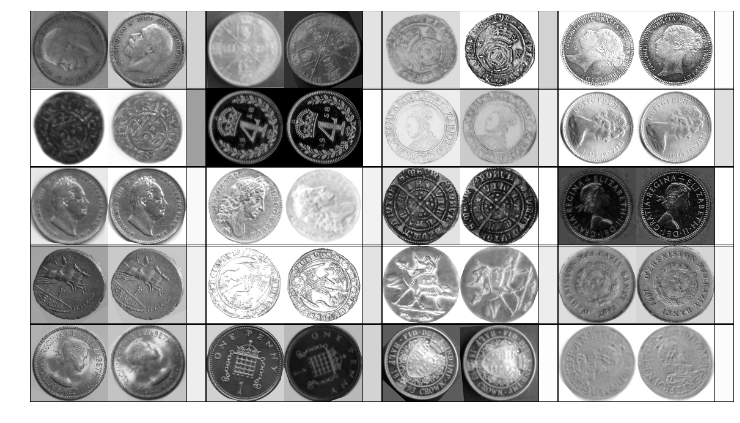

0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.25 0.04 0.01 0.00 0.00 0.00 0.03 0.00 0.54 0.60 0.00 0.00 0.00
                                                                           ==== ====               


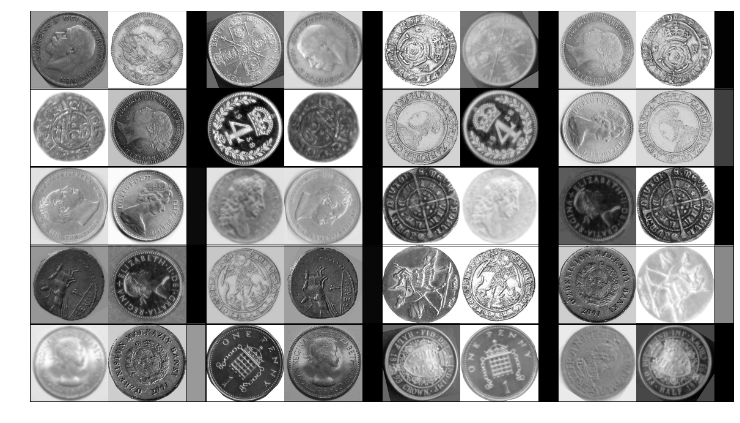

CPU times: user 1.56 s, sys: 352 ms, total: 1.92 s
Wall time: 1.6 s


In [12]:
%%time
def show_similarity(img1, img2, sim, cols=4):
    num = img1.shape[0]
    h   = img1.shape[1]
    w   = img1.shape[2]
    w3  = 32
    img1 = np.copy(img1.reshape([num*h,w]))
    img2 = np.copy(img2.reshape([num*h,w]))
    img3 = np.ones([num*h, w3])
    for i in range(num):
        s = sim[i]
        assert(0.<=s<=1.)
        img3[i*h:i*h+h] = s
    img1[:,0] = 0
    img3[:,w3-1] = 0
    img3[:,0] = 0
    sheet = np.concatenate([img1, img2, img3], axis=1)
    sheet[np.arange(0,num*h,h)-1,:] = 0
    sheet[np.arange(0,num*h,h)+1,:] = 0
    sheet = np.minimum(sheet, 1)
    print(' '.join(['%.2f'%s for s in sim]))
    print(' '.join(['='*4 if s>.5 else ' '*4 for s in sim]))    
    show_images(images=sheet, image_shape=[h, 2*w+w3], cols=cols, rows=num//cols)
    
def test_similarity(model, num):
    assert model, "Model is not defined"
    images  = model.data.test_images
    shift   = np.random.randint(len(images))
    
    # positive
    im1 = np.roll(images, shift, axis=0)[:num]
    im2 = im1
    im1 = model.augment(im1)
    im2 = model.augment(im2)
    sim = model.get_similarity(im1, im2)
    show_similarity(im1, im2, sim) 
    
    # negative
    im1 = np.roll(images, shift  , axis=0)[:num]
    im2 = np.roll(images, shift+1, axis=0)[:num]
    im1 = model.augment(im1)
    im2 = model.augment(im2)
    sim = model.get_similarity(im1, im2)
    show_similarity(im1, im2, sim) 

if global_run_tests:
    test_similarity(_sim_model, num=20)

### Test quality

Data size   : 500
Mean pos sim: 92.6%
Mean neg sim: 7.3%


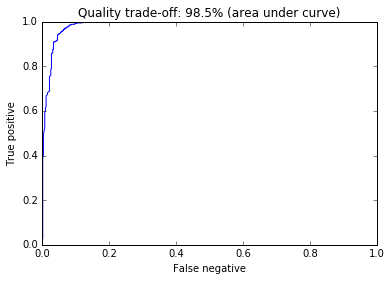

CPU times: user 12.5 s, sys: 356 ms, total: 12.9 s
Wall time: 12.7 s


In [13]:
%%time
def show_quality(pos_sim, neg_sim):
    print("Data size   :", len(pos_sim))
    print("Mean pos sim: %.1f%%" % (np.mean(pos_sim)*100))
    print("Mean neg sim: %.1f%%" % (np.mean(neg_sim)*100))
    n = 1000
    x = np.zeros(n)
    y = np.zeros(n)
    s = 0
    for i in range(n):
        p = i/n
        x[i] = 1 - np.mean(neg_sim < p)
        y[i] = np.mean(pos_sim > p)
        if i>0:
            s += (y[i]+y[i-1])/2 * (x[i-1]-x[i])
    plt.plot(x, y)
    plt.title("Quality trade-off: %.1f%% (area under curve)" % (s*100))
    plt.xlabel("False negative")
    plt.ylabel("True positive")
    plt.show()

def test_quality(model):
    assert model, "Model is not defined"
    images = model.data.test_images
    num    = min(500, len(images))
    shift  = np.random.randint(len(images))
    
    # positive
    im1 = np.roll(images, shift, axis=0)[:num]
    im2 = im1
    im1 = model.augment(im1)
    im2 = model.augment(im2)
    pos = model.get_similarity(im1, im2)
    
    # negative
    im1 = np.roll(images, shift  , axis=0)[:num]
    im2 = np.roll(images, shift+1, axis=0)[:num]
    im1 = model.augment(im1)
    im2 = model.augment(im2)
    neg = model.get_similarity(im1, im2)
    
    show_quality(pos_sim = pos, neg_sim = neg)

if global_run_tests:
    test_quality(_sim_model)